In [1]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (515/515), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 515 (delta 384), reused 443 (delta 312), pack-reused 0
Receiving objects: 100% (515/515), 3.27 MiB | 2.24 MiB/s, done.
Resolving deltas: 100% (384/384), done.


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
from Eunomia.degree import *
from Eunomia.experiments import *
pyro.set_rng_seed(1)

def linear_scaling(x):
    return x / x.sum()

def pol_scaling(x , degree = 3):
    y = np.power(x, degree)
    return y / y.sum()


def scale(suffrages, scaling_functions):
    nsf = []
    for i in range(suffrages.shape[0]):
        nsf.append(scaling_functions[i](suffrages[i, :]))
    return np.array(nsf)

def evaluate_coalition(coalition, effectifs):
    return np.where(effectifs[:, coalition].sum(axis = 1) > 0.5)[0].shape[0]

def compute_data(n_partis, evaluation_function, effectifs):
    alternatives = [sparse_to_alt(tuple(i), n_partis) for i in generate_additive_theta(n_partis,n_partis - 1)]
    theta = [tuple(i) for i in generate_additive_theta(n_partis,n_partis-1)]
    ranks = []
    for a in alternatives:
        ranks.append(evaluation_function(alt_to_sparse(a), effectifs))
    alternatives = np.array(alternatives)
    ranks = np.array(ranks)
    preferences = PreferenceModel(alternatives, ranks)
    data = preferences.generate_preference_matrix(theta)
    data = torch.tensor(data).float()
    return data, theta, preferences


def plot_normal_distributions(means, stds, labels):
    """
    Plots the normal distributions given lists of means, standard deviations, and labels.
    
    Parameters:
    means (list): A list of means for the normal distributions.
    stds (list): A list of standard deviations for the normal distributions.
    labels (list): A list of labels for each distribution.
    """
    # Check if all lists are of the same length
    if not (len(means) == len(stds) == len(labels)):
        raise ValueError("All input lists must be of the same length")

    # Create a range of x values
    x = np.linspace(min(means) - 3 * max(stds), max(means) + 3 * max(stds), 1000)

    # Plot each normal distribution
    for mean, std, label in zip(means, stds, labels):
        y = norm.pdf(x, mean, std)
        plt.plot(x, y, label=label)

    plt.title("Normal Distributions")
    plt.xlabel("Value")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.show()

In [9]:
suffrages = np.array([
        np.array([100, 25, 15]),
        np.array([100, 15, 25]),
])

sigma_w = 1
sigma_p = 1e-5
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [01:17, 32.11it/s, step size=2.89e-01, acc. prob=0.846]


(array([   4.,    4.,    7.,    7.,   14.,   27.,   30.,   73.,  198.,
        1136.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

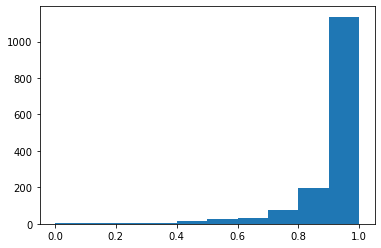

In [10]:
accs_d = get_acc_distribution(data, sampled_weights, sigmas)
plt.hist(accs_d)

In [12]:
svs = np.array([compute_semivalues(N_PARTYS, theta, weights, lambda x:(1/x)) for weights in sampled_weights])

In [31]:
means, stds = svs.mean(axis = 0), svs.std(axis = 0)


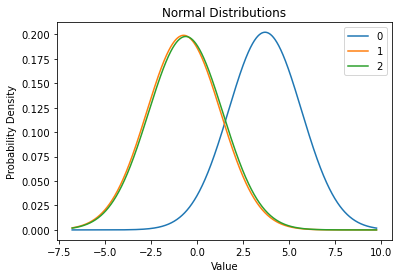

In [32]:
plot_normal_distributions(means, stds, ["0", "1", "2"])

In [39]:
suffrages = np.array([
        np.array([50, 10, 40]),
        np.array([50, 10, 40]),
])

sigma_w = 1e1
sigma_p = 1
n_samples = 1500

effectifs = scale(suffrages, [linear_scaling, linear_scaling])
data, theta, preferences = compute_data(effectifs.shape[1], evaluate_coalition,effectifs)



Sample: 100%|████████████████████████████| 2500/2500 [03:22, 12.35it/s, step size=8.26e-02, acc. prob=0.797]


In [44]:
preferences

(0, 2) > (0,)
(0, 1) > (0,)
(0, 2) > (1, 2)
(0, 2) > (2,)
(0, 1) > (1, 2)
(0, 1) > (2,)
(0, 2) > (1,)
(0, 1) > (1,)

In [ ]:
model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

(array([   6.,    0.,    0.,    0.,    0.,   52.,    0.,    0.,    0.,
        1442.]),
 array([0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925, 0.95 ,
        0.975, 1.   ], dtype=float32),
 <BarContainer object of 10 artists>)

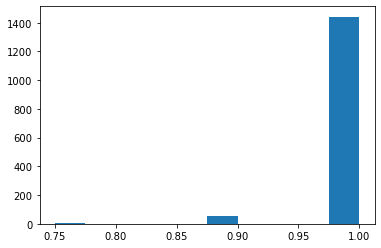

In [40]:
accs_d = get_acc_distribution(data, sampled_weights, sigmas)
plt.hist(accs_d)

In [42]:
svs = np.array([compute_semivalues(N_PARTYS, theta, weights, lambda x:(1/x)) for weights in sampled_weights])

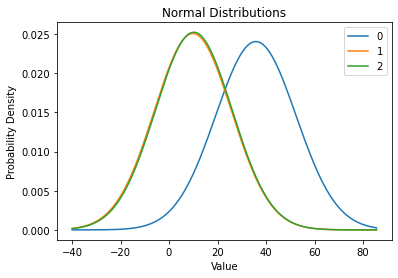

In [43]:
means, stds = svs.mean(axis = 0), svs.std(axis = 0)
plot_normal_distributions(means, stds, ["0", "1", "2"])

In [56]:
suffrages = np.array([
        np.array([60, 40, 10]),
        np.array([10, 40, 60]),
])

sigma_w = 1e1
sigma_p = 1
n_samples = 1500

effectifs = scale(suffrages, [linear_scaling, linear_scaling])
data, theta, preferences = compute_data(effectifs.shape[1], evaluate_coalition,effectifs)


In [57]:
preferences

(0, 2) > (0,)
(0,) > (1,)
(2,) > (1,)
(0, 2) > (2,)
(0, 2) > (1, 2)
(0, 2) > (0, 1)
(1, 2) > (1,)
(0, 2) > (1,)
(0, 1) > (1,)

In [58]:
model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [03:46, 11.03it/s, step size=1.07e-01, acc. prob=0.771]


(array([   6.,    0.,    0.,    0.,    0.,   74.,    0.,    0.,    0.,
        1420.]),
 array([0.7777778 , 0.8       , 0.82222223, 0.84444445, 0.8666667 ,
        0.8888889 , 0.9111111 , 0.93333334, 0.95555556, 0.9777778 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

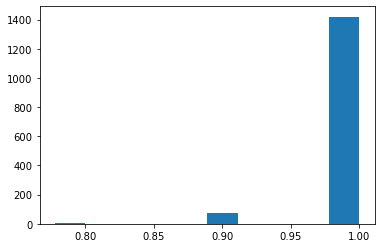

In [59]:
accs_d = get_acc_distribution(data, sampled_weights, sigmas)
plt.hist(accs_d)

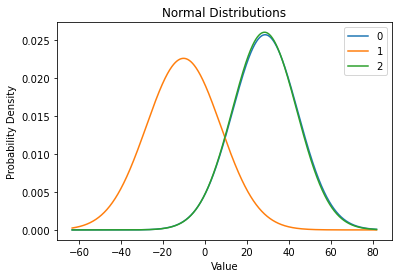

In [60]:
svs = np.array([compute_semivalues(N_PARTYS, theta, weights, lambda x:(1/x)) for weights in sampled_weights])
means, stds = svs.mean(axis = 0), svs.std(axis = 0)
plot_normal_distributions(means, stds, ["0", "1", "2"])

## Large scale experiments

In [73]:
def sample_suffrages(n, m):
    suffrages = np.random.randint(0,100,(N_CHAMBERS, N_PARTYS)).astype(float)
    for i in range(suffrages.shape[0]):
        suffrages[i, :] = suffrages[i, :] / suffrages[i, :].sum()
    return suffrages

In [76]:
suffrages = sample_suffrages(3, 2)
data, theta, preferences = compute_data(effectifs.shape[1], evaluate_coalition, suffrages)
data

tensor([[-1.,  0.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.],
        [-1., -1.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  1.,  0.],
        [ 1., -1.,  1.,  0.,  1.,  0.],
        [ 0., -1.,  1., -1.,  1.,  0.],
        [-1.,  1.,  1.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.],
        [-1.,  0.,  1., -1.,  0.,  1.]])

In [80]:
model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [03:19, 12.52it/s, step size=8.32e-02, acc. prob=0.824]


In [86]:
sampled_weights.mean(axis = 0)

tensor([-3.7234, -2.8263, 13.0491, -2.4923,  4.3197,  3.6326])

In [84]:
for w in sampled_weights:
    sv = compute_semivalues(N_PARTYS, theta, w, lambda x:(1/x))
    sums = suffrages.sum(axis = 0)
    sv_s = sv.argsort()
    sums_s = sums.argsort()


In [133]:
import time

n = 3
c = 2
N_EXP = 25
sigma_w = 10
sigma_p = 1e-2
n_samples = 1500
warmup = 1000
TEST_NAME = "MC1"
REPLACE = False

for n in range(3, 12):
    for c in range(2,n):
        for i in range(N_EXP):
            run_d = {
                "id":i,
                "n": n,
                "c": c,
                "sigma_w": sigma_w,
                "sigma_p": sigma_p,
                "warmup":warmup,
                "n_samples": n_samples
            }
            found = find_experiment_file(run_d, TEST_NAME)
            if found:
                date = found
                print(f"Found file: {file_name}")
                if REPLACE:
                    print('Replacing it...')
                else:
                    continue
            else:
                file_name = compute_experiment_file_name(run_d, TEST_NAME)
                print("Registering the results in: ", file_name)
            ####
            suffrages = sample_suffrages(n, c)
            t = time.time()
            data, theta, preferences = compute_data(suffrages.shape[1], evaluate_coalition, suffrages)
            model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
            t = time.time() - t
            diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=warmup, num_samples=n_samples, return_diag=True)
            accs_d = get_acc_distribution(data, sampled_weights, sigmas)
            predicted_rankings = [np.argsort(compute_semivalues(n, theta, weights, lambda x:1))[::-1] for weights in sampled_weights]
            sv_dists = [compute_semivalues(n, theta, weights, lambda x:1) for weights in sampled_weights]
            
            file_path = record_experiment_results(run_d, TEST_NAME)

            
            run_d["time"] = t
            run_d["suffrages"] = [i.tolist() for i in suffrages]
            run_d["semivalues_distributions"] = sv_dists
            run_d["predicted_rankings"] = [i.tolist() for i in predicted_rankings]
            run_d["accuracy_distribution"] = [i.tolist() for i in accs_d]
            run_d["acceptance_rate"] = diag["acceptance rate"]["chain 0"]
            run_d["w_eff"] = [float(i) for i in diag["w"]["n_eff"].numpy()]
            run_d["w_rhat"] = [float(i) for i in diag["w"]["r_hat"].numpy()]
            
            print(f'{i} : {run_d["w_eff"]}, {run_d["w_rhat"]}')
            with open(file_path, 'w') as file:
                yaml.dump(run_d, file, default_flow_style=False)
            break

Found file: MC1/2023-12-05/id-0_n-9_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-3_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:49, 50.24it/s, step size=1.75e-01, acc. prob=0.908]


1 : [884.312255859375, 669.5452880859375, 679.955078125, 709.75390625, 731.1689453125, 705.4691162109375], [1.0005584955215454, 1.0013290643692017, 0.9999376535415649, 1.0030540227890015, 1.0007826089859009, 1.0046169757843018]
Found file: MC1/2023-12-05/id-1_n-3_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-4_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 68.09it/s, step size=2.76e-01, acc. prob=0.797]


1 : [608.6331787109375, 593.2279052734375, 648.7103271484375, 626.7596435546875, 766.291748046875, 659.11962890625], [1.0025449991226196, 0.9993335604667664, 1.0027003288269043, 0.9993711113929749, 0.9994754791259766, 0.9994176626205444]
Found file: MC1/2023-12-05/id-1_n-4_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-4_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:51, 48.45it/s, step size=2.16e-01, acc. prob=0.854]


1 : [544.4527587890625, 727.0187377929688, 795.9197998046875, 936.8676147460938, 751.9549560546875, 808.4800415039062], [0.9993392825126648, 0.9993482232093811, 0.9994722604751587, 1.0006747245788574, 0.9993374943733215, 1.0021294355392456]
Found file: MC1/2023-12-05/id-1_n-4_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-5_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:38, 64.37it/s, step size=2.99e-01, acc. prob=0.817]


1 : [820.7083129882812, 938.5345458984375, 900.25634765625, 861.95166015625, 1027.2452392578125, 739.6224975585938], [0.9994787573814392, 1.0007442235946655, 1.0006977319717407, 1.000946044921875, 0.9995532631874084, 1.0036709308624268]
Found file: MC1/2023-12-05/id-1_n-5_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-5_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:40, 61.80it/s, step size=2.95e-01, acc. prob=0.863]


1 : [1107.3975830078125, 884.4815673828125, 1126.341552734375, 1183.3135986328125, 1149.13037109375, 1076.517578125], [0.9993578195571899, 0.9999035596847534, 1.0011231899261475, 0.9993331432342529, 0.9998290538787842, 1.001151442527771]
Registering the results in:  MC1/2023-12-05/id-0_n-5_c-4_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:31, 78.27it/s, step size=3.79e-01, acc. prob=0.824]


0 : [840.4901123046875, 963.9234008789062, 1048.640625, 1002.7677001953125, 1093.5206298828125, 1101.762939453125], [0.9994764924049377, 0.9997808337211609, 0.9994473457336426, 0.999423086643219, 0.9994521141052246, 1.0020439624786377]
Found file: MC1/2023-12-05/id-0_n-5_c-4_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-6_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 67.71it/s, step size=3.33e-01, acc. prob=0.810]


1 : [752.6259765625, 817.571533203125, 1027.0838623046875, 854.8521728515625, 1033.811279296875, 966.6406860351562], [0.9994125962257385, 0.9997393488883972, 1.0002080202102661, 0.9993396997451782, 0.999510645866394, 1.0037758350372314]
Found file: MC1/2023-12-05/id-1_n-6_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-6_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:35, 70.20it/s, step size=2.95e-01, acc. prob=0.820]


1 : [831.762939453125, 495.7918395996094, 639.6075439453125, 570.228759765625, 946.7896728515625, 755.2850341796875], [1.0006076097488403, 0.9993582367897034, 0.9993484616279602, 1.0001767873764038, 0.9993335008621216, 0.9993971586227417]
Registering the results in:  MC1/2023-12-05/id-0_n-6_c-4_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:39, 62.65it/s, step size=2.77e-01, acc. prob=0.790]


0 : [847.6900024414062, 562.42041015625, 780.533203125, 676.9281616210938, 685.5556640625, 714.6749267578125], [1.000121831893921, 1.0042529106140137, 0.9999690651893616, 1.0026696920394897, 0.9996440410614014, 0.9997008442878723]
Registering the results in:  MC1/2023-12-05/id-0_n-6_c-5_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 69.18it/s, step size=3.37e-01, acc. prob=0.839]


0 : [928.6959838867188, 800.3997802734375, 992.6221923828125, 822.9940795898438, 1025.357666015625, 1094.8392333984375], [0.999472975730896, 1.0036330223083496, 1.0013854503631592, 1.0008472204208374, 1.0019373893737793, 0.9999350905418396]
Found file: MC1/2023-12-05/id-0_n-6_c-5_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-7_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:33, 75.58it/s, step size=3.91e-01, acc. prob=0.796]


1 : [1092.76318359375, 585.7640380859375, 946.1132202148438, 778.0208740234375, 895.0362548828125, 846.8505249023438], [1.0001059770584106, 0.9993639588356018, 0.9996577501296997, 0.9997503757476807, 1.0000746250152588, 0.9994142651557922]
Found file: MC1/2023-12-05/id-1_n-7_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-7_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:44, 56.45it/s, step size=2.46e-01, acc. prob=0.798]


1 : [323.8794860839844, 456.4980773925781, 852.8465576171875, 745.4465942382812, 648.774658203125, 734.501220703125], [1.0019301176071167, 1.0010309219360352, 1.002511739730835, 0.9993886947631836, 0.9993861317634583, 0.9996323585510254]
Registering the results in:  MC1/2023-12-05/id-0_n-7_c-4_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:44, 55.89it/s, step size=2.55e-01, acc. prob=0.832]


0 : [833.4484252929688, 636.6691284179688, 783.3192138671875, 942.4883422851562, 944.381103515625, 915.318603515625], [0.9993614554405212, 1.0043545961380005, 0.9993391036987305, 1.0035837888717651, 1.0006468296051025, 1.0019164085388184]
Registering the results in:  MC1/2023-12-05/id-0_n-7_c-5_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:43, 57.77it/s, step size=2.83e-01, acc. prob=0.857]


0 : [1065.862060546875, 987.5264282226562, 1026.0721435546875, 1098.9281005859375, 1211.004638671875, 1086.8798828125], [0.9995007514953613, 0.9999872446060181, 0.9993434548377991, 0.9993357062339783, 0.9995423555374146, 1.0004955530166626]
Registering the results in:  MC1/2023-12-05/id-0_n-7_c-6_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:41, 60.83it/s, step size=2.48e-01, acc. prob=0.865]


0 : [1030.9232177734375, 965.2125244140625, 1180.23095703125, 846.91650390625, 1243.192138671875, 813.5579833984375], [1.003743290901184, 1.0020757913589478, 1.0019960403442383, 0.9994639754295349, 1.0008796453475952, 0.9993930459022522]
Found file: MC1/2023-12-05/id-0_n-7_c-6_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-8_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:43, 57.97it/s, step size=2.25e-01, acc. prob=0.854]


1 : [797.855712890625, 661.2330322265625, 834.2217407226562, 901.2679443359375, 685.9176635742188, 870.3756713867188], [0.999403715133667, 0.9997426867485046, 0.9998469352722168, 0.9994466304779053, 0.9993768334388733, 0.9998565912246704]
Found file: MC1/2023-12-05/id-1_n-8_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-8_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:38, 65.43it/s, step size=2.79e-01, acc. prob=0.785]


1 : [474.5341796875, 450.6368103027344, 936.9036254882812, 136.91873168945312, 841.8666381835938, 232.3909912109375], [1.0017743110656738, 1.0001845359802246, 1.0003279447555542, 0.999428391456604, 1.0001457929611206, 0.9998358488082886]
Registering the results in:  MC1/2023-12-05/id-0_n-8_c-4_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:28, 88.03it/s, step size=4.17e-01, acc. prob=0.741]


0 : [880.3734130859375, 813.285400390625, 906.7054443359375, 891.2676391601562, 782.0521240234375, 972.9795532226562], [1.0011932849884033, 0.9999712705612183, 0.9997745156288147, 0.9993650913238525, 0.9994176030158997, 0.999354362487793]
Registering the results in:  MC1/2023-12-05/id-0_n-8_c-5_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:33, 74.10it/s, step size=3.09e-01, acc. prob=0.811]


0 : [762.1349487304688, 959.2601318359375, 878.4694213867188, 938.0905151367188, 773.5390625, 774.751708984375], [1.0010380744934082, 0.9996045827865601, 0.9998372197151184, 0.9993346333503723, 1.0019735097885132, 1.0006190538406372]
Registering the results in:  MC1/2023-12-05/id-0_n-8_c-6_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:33, 75.12it/s, step size=3.80e-01, acc. prob=0.778]


0 : [564.9533081054688, 742.443115234375, 690.4754638671875, 868.3590698242188, 892.002685546875, 854.755615234375], [0.9993542432785034, 0.9999112486839294, 0.999510645866394, 0.9993816018104553, 1.000303864479065, 0.9998295903205872]
Registering the results in:  MC1/2023-12-05/id-0_n-8_c-7_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:38, 64.64it/s, step size=2.55e-01, acc. prob=0.834]


0 : [948.1734008789062, 890.6396484375, 1037.98828125, 755.5716552734375, 847.8923950195312, 901.3018798828125], [1.0019893646240234, 1.000887155532837, 0.999334454536438, 0.9996821284294128, 1.000636339187622, 0.9993730187416077]
Found file: MC1/2023-12-05/id-0_n-8_c-7_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-9_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:45, 54.87it/s, step size=1.88e-01, acc. prob=0.921]


1 : [840.366943359375, 886.7913208007812, 574.4674682617188, 1007.9367065429688, 1059.292236328125, 950.9920654296875], [0.9995523691177368, 0.999997079372406, 0.9995989203453064, 1.0007199048995972, 0.9996019601821899, 0.9993342757225037]
Found file: MC1/2023-12-05/id-1_n-9_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml
Registering the results in:  MC1/2023-12-05/id-1_n-9_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:43, 57.94it/s, step size=2.61e-01, acc. prob=0.871]


1 : [950.0379638671875, 1131.5782470703125, 865.06298828125, 1024.820068359375, 971.759521484375, 894.3023071289062], [0.9996952414512634, 1.0011264085769653, 0.9994624257087708, 0.9997723698616028, 1.000133991241455, 0.9994322657585144]
Registering the results in:  MC1/2023-12-05/id-0_n-9_c-4_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:40, 61.99it/s, step size=2.73e-01, acc. prob=0.839]


0 : [653.6759033203125, 968.7777709960938, 826.7506713867188, 812.1748657226562, 919.5709228515625, 861.7316284179688], [0.9997780323028564, 0.9998415112495422, 1.0001920461654663, 1.0051634311676025, 1.001470685005188, 0.9998536109924316]
Registering the results in:  MC1/2023-12-05/id-0_n-9_c-5_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 69.32it/s, step size=3.36e-01, acc. prob=0.763]


0 : [827.778076171875, 727.3062133789062, 923.7811279296875, 648.87255859375, 719.0892944335938, 687.0886840820312], [1.0004717111587524, 1.001272439956665, 1.0001717805862427, 1.0002508163452148, 1.0023655891418457, 1.004818320274353]
Registering the results in:  MC1/2023-12-05/id-0_n-9_c-6_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:39, 63.14it/s, step size=2.32e-01, acc. prob=0.856]


0 : [928.6424560546875, 637.6892700195312, 665.0338745117188, 647.6233520507812, 781.7499389648438, 904.13916015625], [0.9999766945838928, 0.9994544386863708, 1.000745177268982, 0.9996589422225952, 1.0004026889801025, 0.9993621110916138]
Registering the results in:  MC1/2023-12-05/id-0_n-9_c-7_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:35, 69.84it/s, step size=3.44e-01, acc. prob=0.801]


0 : [957.8043212890625, 839.4478149414062, 728.5989379882812, 991.7362060546875, 728.001220703125, 939.8846435546875], [0.9998877644538879, 0.9998154640197754, 1.000683307647705, 1.0023918151855469, 1.0024348497390747, 0.9997344613075256]
Registering the results in:  MC1/2023-12-05/id-0_n-9_c-8_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 67.85it/s, step size=3.85e-01, acc. prob=0.775]


0 : [883.4974975585938, 912.159912109375, 642.4667358398438, 914.50390625, 694.7073974609375, 902.0836791992188], [1.0022038221359253, 1.0002490282058716, 0.9993473887443542, 0.9995514154434204, 1.001766324043274, 1.000293493270874]
Registering the results in:  MC1/2023-12-05/id-0_n-10_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:37, 66.39it/s, step size=3.26e-01, acc. prob=0.743]


0 : [562.5201416015625, 535.9277954101562, 603.0818481445312, 709.4368896484375, 538.4925537109375, 607.519775390625], [1.0007877349853516, 0.9993831515312195, 0.999858021736145, 1.0007129907608032, 0.9993770718574524, 1.0009324550628662]
Registering the results in:  MC1/2023-12-05/id-0_n-10_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:31, 79.77it/s, step size=3.73e-01, acc. prob=0.818]


0 : [973.5108642578125, 1037.306396484375, 946.1669921875, 1174.30517578125, 847.7959594726562, 1192.1597900390625], [0.99994295835495, 0.99967360496521, 0.9998546242713928, 0.9993340969085693, 0.9993435740470886, 1.0010226964950562]
Registering the results in:  MC1/2023-12-05/id-0_n-10_c-4_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:40, 62.41it/s, step size=3.21e-01, acc. prob=0.832]


0 : [938.55322265625, 839.7877807617188, 972.8456420898438, 984.8840942382812, 974.6365966796875, 982.5115966796875], [1.0012531280517578, 1.0011985301971436, 0.9998844265937805, 0.9994811415672302, 0.9998055696487427, 0.9995017647743225]
Registering the results in:  MC1/2023-12-05/id-0_n-10_c-5_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:46, 53.62it/s, step size=2.62e-01, acc. prob=0.835]


0 : [499.2327575683594, 977.7705688476562, 736.6423950195312, 871.5426025390625, 1126.404541015625, 695.0751342773438], [1.0000587701797485, 1.0004150867462158, 0.9993812441825867, 0.9996569752693176, 0.9994459748268127, 1.0004273653030396]
Registering the results in:  MC1/2023-12-05/id-0_n-10_c-6_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:42, 58.94it/s, step size=2.51e-01, acc. prob=0.853]


0 : [914.3666381835938, 808.2937622070312, 540.1914672851562, 732.4943237304688, 1052.795166015625, 662.3421630859375], [0.9998254776000977, 1.002395749092102, 0.9997344613075256, 0.9993564486503601, 0.9993517994880676, 0.9995706677436829]
Registering the results in:  MC1/2023-12-05/id-0_n-10_c-7_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 68.62it/s, step size=2.71e-01, acc. prob=0.873]


0 : [1056.2591552734375, 1037.3514404296875, 1215.7025146484375, 1298.58984375, 1171.3228759765625, 1156.7479248046875], [0.9994025826454163, 0.9996927976608276, 0.9993804097175598, 0.9994514584541321, 1.0018595457077026, 1.0000288486480713]
Registering the results in:  MC1/2023-12-05/id-0_n-10_c-8_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:56, 44.41it/s, step size=1.55e-01, acc. prob=0.919]


0 : [744.1755981445312, 691.6771240234375, 497.6528625488281, 903.7794189453125, 581.0626831054688, 880.5970458984375], [0.9993652105331421, 1.0040994882583618, 1.0016947984695435, 1.0020394325256348, 1.0025240182876587, 1.0036840438842773]
Registering the results in:  MC1/2023-12-05/id-0_n-10_c-9_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:35, 71.04it/s, step size=3.61e-01, acc. prob=0.812]


0 : [1037.344482421875, 866.4310913085938, 1063.7039794921875, 738.3788452148438, 990.2205810546875, 1098.9158935546875], [0.9995718002319336, 0.9993619322776794, 1.0001490116119385, 0.9994850754737854, 1.000304102897644, 1.0003323554992676]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-2_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 68.23it/s, step size=2.94e-01, acc. prob=0.790]


0 : [688.0902099609375, 583.8849487304688, 509.6253967285156, 588.8876342773438, 603.7852172851562, 435.69390869140625], [0.9996135830879211, 1.0016682147979736, 1.0018802881240845, 1.0002000331878662, 0.9994879364967346, 1.00262451171875]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-3_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:38, 65.56it/s, step size=2.96e-01, acc. prob=0.818]


0 : [855.7105712890625, 940.2977294921875, 962.3306274414062, 679.3260498046875, 893.0151977539062, 803.2570190429688], [0.9995349645614624, 0.999759316444397, 0.9993351697921753, 0.9999160170555115, 1.0004462003707886, 0.999626636505127]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-4_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:34, 73.13it/s, step size=2.79e-01, acc. prob=0.797]


0 : [709.8837890625, 820.502197265625, 902.0404052734375, 994.878173828125, 711.0066528320312, 907.4644165039062], [0.9995224475860596, 0.9994410276412964, 1.0044581890106201, 1.0000998973846436, 1.001186490058899, 1.0003063678741455]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-5_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:39, 63.65it/s, step size=2.86e-01, acc. prob=0.787]


0 : [668.3323364257812, 620.427001953125, 594.04052734375, 629.3798828125, 495.4382629394531, 436.9888916015625], [0.9995329976081848, 1.000019907951355, 1.0004353523254395, 0.9993565678596497, 1.0020511150360107, 1.001174807548523]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-6_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:38, 64.20it/s, step size=2.89e-01, acc. prob=0.783]


0 : [864.4136352539062, 676.0990600585938, 639.4486694335938, 631.292236328125, 682.8878784179688, 669.7599487304688], [1.002858281135559, 1.0016467571258545, 1.0089513063430786, 1.001455545425415, 0.9997736215591431, 1.0006698369979858]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-7_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:43, 56.87it/s, step size=2.49e-01, acc. prob=0.841]


0 : [561.1876831054688, 762.1754150390625, 864.0921630859375, 638.7942504882812, 964.3570556640625, 765.488037109375], [0.9993734955787659, 1.0049694776535034, 1.0001780986785889, 0.9993730783462524, 0.9998224377632141, 0.9993425011634827]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-8_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:56, 44.19it/s, step size=1.65e-01, acc. prob=0.900]


0 : [572.9200439453125, 912.8326416015625, 572.740966796875, 352.9707336425781, 728.3632202148438, 934.357177734375], [0.9999493360519409, 0.9994410872459412, 0.9995003342628479, 1.005200743675232, 0.9995048642158508, 0.9997233152389526]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-9_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 68.53it/s, step size=3.07e-01, acc. prob=0.776]


0 : [973.8555297851562, 561.214599609375, 714.0825805664062, 650.0447387695312, 629.5521240234375, 593.6666259765625], [1.001956582069397, 1.0003610849380493, 1.0005840063095093, 0.9993847012519836, 1.0083285570144653, 1.0017460584640503]
Registering the results in:  MC1/2023-12-05/id-0_n-11_c-10_sigma_w-10_sigma_p-0.01_warmup-1000_n_samples-1500.yaml


Sample: 100%|████████████████████████████| 2500/2500 [00:36, 68.22it/s, step size=3.26e-01, acc. prob=0.802]


0 : [961.6834106445312, 1010.9554443359375, 1017.933837890625, 951.5770263671875, 843.3773803710938, 915.7653198242188], [1.0020043849945068, 0.9996213912963867, 1.0006449222564697, 1.0030211210250854, 1.0005114078521729, 1.0005782842636108]


(array([658.,   0.,   0., 701.,   0.,   0.,  79.,   0.,   0.,  62.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

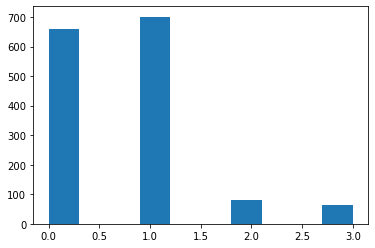

In [124]:
plt.hist(np.array(distance_dists).mean(axis = 0))

In [125]:
np.argsort(mean_weights)

array([[0, 2, 1]])

In [126]:
np.argsort(mean_svs)

array([[0, 1, 2]])

In [127]:
suffrages

array([[0.14728682, 0.59689922, 0.25581395],
       [0.03636364, 0.35454545, 0.60909091]])